В первой части этого ipython notebook рассматривается сверточный слой нейронной сети, возможные способы его реализации, а также особые виды сверточных слоев. 

Вторая часть содержит пример использования утилиты tensorboard для визуализации архитектуры нейронной сети и для мониторинга различных значений в процессе обучения и тестирования (ошибка, точность и т.д.).

# Сверточный слой (2D convolution):

## Описание слоя

* Входные данные: 
    массив размером $C~\times~W_{in}~\times~H_{in}$, где $C$ - число каналов, $W_{in}$ и $H_{in}$ - ширина и высота входных карт признаков соответственно;


* Параметры слоя:
    * $K$ - размер ядра (для простоты рассматриваем только квадратные свертки, хотя на практике могут применяться и прямоугольные, например в этой [работе](https://arxiv.org/pdf/1512.00567.pdf "Rethinking the Inception Architecture for Computer Vision"));
    * $D$ - число фильторов;
    * $S$ - шаг (stride, для упрощения изложения считается, что $S_x=S_y=S$, хотя на практике могут использоваться разные размеры шага вдоль разных осей);
    * $P$ - дополнение (padding);


* Результат работы слоя: 
    массив размером $D~\times~W_{out}~\times~H_{out}$, где $D$ - число фильтров в слое, $W_{out}=\frac{W_{in}-K+2P}{S}+1$ и $H_{out}=\frac{H_{in}-K+2P}{S}+1$ - ширина и высота карт признаков на выходе соответственно;


* Число параметров в слое: 
    $D*(K*K*C)+D$, где первое слагаемое равно числу весов в $D$ фильтрах, каждый из которых обрабатывает все каналы входных данных, а второе слагаемое - количество смещений (bias), которые прибавляются к результату поканально.
    
**Замечание:** по строгому определению, рассматриваемая нами в этом ноутбуке операция называется кросс-корреляция, а не свертка. Кросс-корреляция $X_{cross-correlation} \star W$ дает такой же результат, как и свертка $X_{convolution} \ast W$ При обучении нейронных сетей веса в фильтрах настраиваются автоматически, а операции кросс-кореляции и свертки работают схожим образом, поэтому выбор рассматриваемой операции значения не имеет.

<img src="pictures/conv-corr.png">

В таблице ниже приведены несколько примеров работы сверток, где синим цветом обозначены входные данные, а зеленым - результат работы свертки. Для наглядности $C = D = 1$.

<table style="width:100%">
    <tr>
        <td style="text-align:center">$K=3,~S=1,~P=0$</td>
        <td style="text-align:center">$K=3,~S=2,~P=0$</td>
        <td style="text-align:center">$K=3,~S=1,~P=2$</td>
        <td style="text-align:center">$K=3,~S=2,~P=1$</td>
    </tr>
    <tr>
        <td><img src="pictures/P0S1.gif"></td>
        <td><img src="pictures/P0S2.gif"></td>
        <td><img src="pictures/P2S1.gif"></td>
        <td><img src="pictures/P1S2.gif"></td>
    </tr>
</table>


## Реализация сверточного слоя с помощью перемножения матриц

### Простая реализация с помощью вложенных циклов

Самый простой способ реализоавть операцию свертки - умножать каждый фрагмент, извлеченный из изображения (со всеми каналами) на фильтр внутри двух вложенных циклов (по высоте и ширине).


### Реализация с помощью преобразования матрицы весов

Более быстрый способ реализации операции свертки заключается в преобразовании матрицы весов так, чтобы результат свертки выражался следующим образом: $dot(W_{transformed}, X_{col})$, где $W_{transformed}$ - преобразованная матрица весов, а $X_{col}$ - в общем случае трехмерный тензор, в котором каждый канал соответствует каналу исходных данных, вытянутому в столбец (слева-направо и сверху-вниз). Например, для первой свертки из таблицы выше исходные и преобразованные матрицы будут выглядеть так:


$$W=\begin{bmatrix}
    w_{00}&w_{01}&w_{02} \\
    w_{10}&w_{11}&w_{12} \\
    w_{20}&w_{21}&w_{22} \\
\end{bmatrix}~~X=\begin{bmatrix}
    x_{00}&x_{01}&x_{02}&x_{03} \\
    x_{10}&x_{11}&x_{12}&x_{13} \\
    x_{20}&x_{21}&x_{22}&x_{23} \\
    x_{30}&x_{31}&x_{32}&x_{33} \\
\end{bmatrix}$$


$$W_{transformed}=\begin{bmatrix}                  
    w_{00}&w_{01}&w_{02}&0&w_{10}&w_{11}&w_{12}&0&w_{20}&w_{21}&w_{22}&0&0&0&0&0 \\
    0&w_{00}&w_{01}&w_{02}&0&w_{10}&w_{11}&w_{12}&0&w_{20}&w_{21}&w_{22}&0&0&0&0 \\
    0&0&0&0&w_{00}&w_{01}&w_{02}&0&w_{10}&w_{11}&w_{12}&0&w_{20}&w_{21}&w_{22}&0 \\
    0&0&0&0&0&w_{00}&w_{01}&w_{02}&0&w_{10}&w_{11}&w_{12}&0&w_{20}&w_{21}&w_{22} \\
\end{bmatrix}$$

$$X_{col}=\begin{bmatrix}                  
    x_{00}&x_{01}&x_{02}&x_{03}&x_{10}&x_{11}&x_{12}&x_{13}&x_{20}&x_{21}&x_{22}&x_{23}&x_{30}&x_{31}&x_{32}&x_{33} \\
\end{bmatrix}^T$$


**Важно заметить**, что если прямой проход для операции свертки выражается, как $dot(W_{transformed}, X_{col})$, то при обратном распространении градиентов при обучении нейронной сети, обратный проход (backward pass) для сверточного слоя будет выражаться, как $dot(W_{transformed}^T, Grad_{col})$, где $Grad_{col}$ - аналогичным образом преобразованная матрица градиентов, дошедших до сверточного слоя при обратном распространении. Таким образом матрица $W_{transformed}$ задает как прямой, так и обратный проход для операции свертки.

Существенный минус этого подхода - огромные накладные расходы на хранение матрицы $W_{transformed}$.

### Быстрая реализация с помощью преобразования входных данных
Другой способ сведения операции свертки к одной операции перемножения матриц состоит в использовании специального преобразования матриц, задающих входные данные, которое сводит свертку к одному большому матричному произведению (это преобразование называется *im2col*, которое подробнее рассмотрено, например, в этой [работе](https://arxiv.org/pdf/1410.0759.pdf)).

На рисунке ниже наглядно изображена свертка, выполняемая с помщью *im2col*. Данные на входе имеют размер $3~\times~3~\times~3$, а параметры сверточного слоя: $K=2$, $D=2$, $S=1$ и $P=0$. Далее по шагам разберем как строятся преобразованные матрицы для входных данных и весов сверточного слоя.


<img src="pictures/im2col.png">


Пусть, на вход сверточному слою подается массив размером $3~\times~224~\times~224$, параметры сверточного слоя: $K=7$, $D=8$, $S=3$, $P=1$ ($8$ фильтров размера $7~\times~7$ с шагом $3$ и дополнением в $1$ пиксель). Тогда свертка выполняется за три следующих шага:
1. Преобразование входных данных.
    * Исходные данные дополняются $P$ пикселями с каждой стороны по одной из возможных стратегий: заполнение фиксированным значением, отражение, дублирование граничного значения или другими.

    * Из исходных данных вырезаются фрагменты, размером $K~\times~K$ с шагом $S$, каждый из которых построчно вытягивается в столбец, солбцы, соответствующие одинаковым фрагментам разных каналов конкатенируются вертикально, а столбцы, соответствующие последовательно извлеченным фрагментам конкатенируются горизонтально. Длина вектора для одного фрагмента всех каналов - $K~\times~K~\times~3$, в нашем случае - $147$, всего таких фрагментов будет $(\frac{W_{in}-K+2*P}{S}+1)*(\frac{H_{in}-K+2*P}{S}+1)$, в нашем случае - $74*74=5476$. Таким образом в итоге мы получаем матрицу $X_{col}$, размером $[147~\times~5476]$.
    
    * Стоить заметить, что так как фрагменты могут накладываться, то в преобразованной матрице будут повторятся некоторые элементы.

2. Преобразование фильтра.
    * Веса фильтра аналогичным образом растягиваются в строки и конкатенируются (каждый канал каждого фильтра растягивается в строку, а после горизонтально конкатенируется с остальными каналами и вертикально конкатенируется с остальными фильтрами).
    
    * В результате получается матрица $W_{row}$ размера $[D~\times~(K*K*C)]$, в нашем случае - $[8~\times~147]$.
    
3. Свертка.

    * Результат свертки после преобразований равен произведению полученных матриц: $dot(W_{row}, X_{col})$. Это соответствует перемножению фильтров с каждой областью видимости (*receptive fielld*) свертки.
    
    * Полученную матрицу нужно преобразовать в правильный размер: из $[8~\times~5476]$ в $[8~\times~74~\times~74]$.
    
    
Очевидным минусом такого подхода к выполнению свертки является дополнительные накладные расходы на повторяющиеся фрагменты исходного изображения в матрице $X_{col}$. Но, во-первых, они меньше, чем расходы в случае преобразования матрицы весов, а во-вторых, ускорение, получаемое за счет эффективной реализации перемножения матриц гораздо существеннее.

### Сравнение

Ниже представлена реализация операции свертки через im2col. Предлагается самостоятельно написать простую реализацию через циклы с использованием готовых шаблонов и сравнить время работы двух реализаций.

#### Вспомогательные функции для реализации свертки через im2col

In [1]:
import numpy as np

def im2col_indices(X_shape, filter_H, filter_W, padding=1, stride=1):
    """
    Returns indexes for an im2col slice
    """
    # Get the output shape
    N, C, H, W = X_shape
    out_H = (H + 2 * padding - filter_H) // stride + 1
    out_W = (W + 2 * padding - filter_W) // stride + 1

    # Get indices for im2col
    i0 = np.repeat(np.arange(filter_H), filter_W)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_H), out_W)
    j0 = np.tile(np.arange(filter_W), filter_H * C)
    j1 = stride * np.tile(np.arange(out_W), out_H)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), filter_H * filter_W).reshape(-1, 1)

    return (k, i, j)


def im2col(X, filter_H, filter_W, padding=1, stride=1):
    """
    An implementation of im2col based on array reindexing
    """
    # Zero-pad the input
    p = padding
    X_padded = np.pad(X, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = im2col_indices(X.shape, filter_H, filter_W, padding, stride)

    cols = X_padded[:, k, i, j]
    C = X.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(filter_H * filter_W * C, -1)
    
    return cols

#### Реализации операции свертки

In [27]:
def conv_im2col(X, kernel, b=None, padding=1, stride=1):
    """
    Convolutional layer implementation with im2col
    """
    N, C, H, W = X.shape
    filter_N, _, filter_H, filter_W = kernel.shape

    # Check dimensions
    assert (W + 2 * padding - filter_W) % stride == 0, 'width does not work'
    assert (H + 2 * padding - filter_H) % stride == 0, 'height does not work'

    # Create output
    out_H = (H + 2 * padding - filter_H) // stride + 1
    out_W = (W + 2 * padding - filter_W) // stride + 1
    out = np.zeros((N, filter_N, out_H, out_W), dtype=np.float64)

    X_cols = im2col(X, filter_H, filter_W, padding, stride)
    if b:
        res = np.dot(kernel.reshape((filter_N, -1)), (X_cols)) + b.reshape(-1, 1)
    else:
        res = np.dot(kernel.reshape((filter_N, -1)), (X_cols))

    out = res.reshape(filter_N, out_H, out_W, N)
    out = out.transpose(3, 0, 1, 2)

    return out

    
def conv_naive(X, kernel, b=None, padding=1, stride=1):
    """
    Convolutional layer implementation with loops
    """
    N, C, H, W = X.shape
    filter_N, _, filter_H, filter_W = kernel.shape

    # Check dimensions
    assert (W + 2 * padding - filter_W) % stride == 0, 'width does not work'
    assert (H + 2 * padding - filter_H) % stride == 0, 'height does not work'

    # Create output
    out_H = (H + 2 * padding - filter_H) // stride + 1
    out_W = (W + 2 * padding - filter_W) // stride + 1
    out = np.zeros((N, filter_N, out_H, out_W), dtype=np.float64)
    
    # Pad input
    p = padding
    X_padded = np.pad(X, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')
    N, C, H, W = X_padded.shape
    
    # Convolve
    for image_number, image in enumerate(X_padded):
        for i in range(out_H):
            for j in range(out_W):
                for channel in range(kernel.shape[0]):
                    out[image_number, channel, i, j] = np.sum(
                        image[
                            :,
                            i * stride : i * stride + filter_H, 
                            j * stride : j * stride + filter_W,
                        ] * kernel[channel]
                    )
    if b:
        return out + b
    
    return out

#### Сравнение по времени работы

In [31]:
from time import time

params = [{'padding': 0, 'stride': 1},
         {'padding': 0, 'stride': 2},
         {'padding': 2, 'stride': 1},
         {'padding': 2, 'stride': 2}]

shapes = [[(3, 3, 33, 33), (64, 3, 1, 1)],
         [(3, 3, 33, 33), (64, 3, 3, 3)],
         [(3, 3, 33, 33), (64, 3, 5, 5)],
         [(3, 3, 33, 33), (64, 3, 7, 7)]]

results = {}

for i, param in enumerate(params):
    for j, shape in enumerate(shapes):
        
        images = np.random.rand(*shape[0])
        kernels = np.random.rand(*shape[1])
        
        for mode, conv in zip(('fast', 'slow'), (conv_im2col, conv_naive)):
            time_begin = time()
            conv(images, kernels, **param)
            time_end = time()
            results[(param['padding'], param['stride'], shape[1][-1], mode)] = time_end - time_begin
        

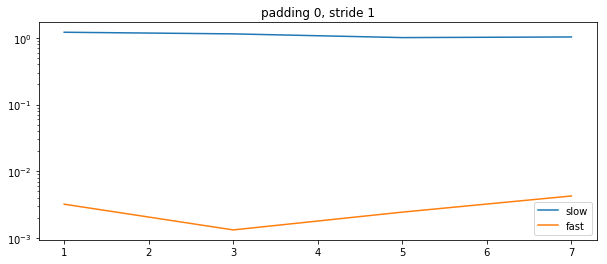

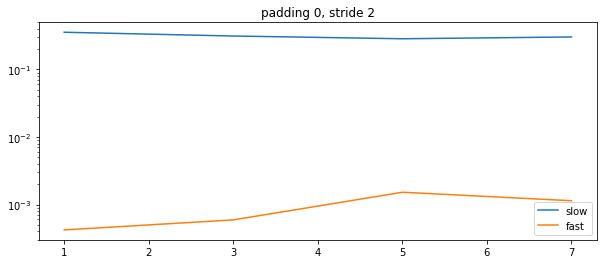

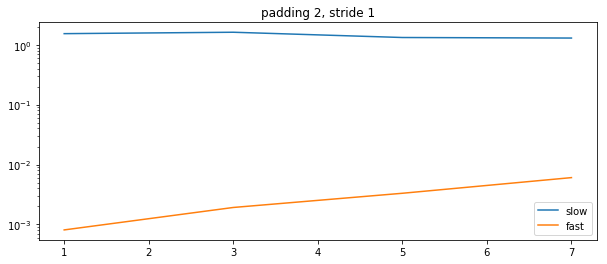

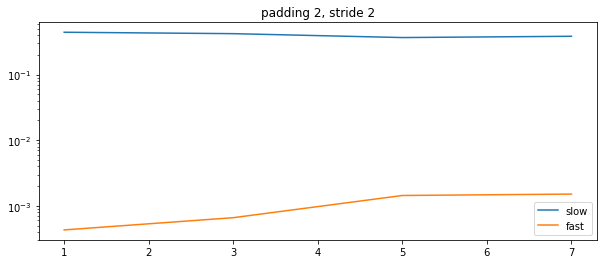

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plt = (1, 3, 5, 7)
for padding in (0, 2):
    for stride in (1, 2):
        plt.figure(figsize=(10, 4))
        for mode in ('slow', 'fast'):
            y_plt = [*map(lambda x: results[(padding, stride, x, mode)], x_plt)]
            plt.plot(x_plt, y_plt, label=mode)
        plt.yscale('log')
        plt.title('padding {padding}, stride {stride}'.format(padding=padding, stride=stride))
        plt.legend()
        plt.show()

Наивный метод работает примерно в 1000 раз медленнее

### Другой способ реализации операции свертки

Ещё один возможный способ реализации свертки использует преобразование Фурье ($\mathcal{F}$), справедливо следующее утверждение:

$$f\ast g = \mathcal{F^{-1}}(\mathcal{F}(f)\circ\mathcal{F}(g))$$

где символом $\ast$ обозначена операция свертки, а $\circ$ обозначает поэлементное произведение. При этом замечено, что при реализации свертки таким способом наибольшее ускорение достигается при больших размерах фильтров.

## Особые виды сверточных слоев

### 2D свертка с размером фильтра $1~\times~1$

Такой вид свертки подробно рассмотрен в [работе](https://arxiv.org/pdf/1312.4400.pdf). Применяются для поканальной комбинации данных с изменением числа каналов. Очень часто используются в архитектурах для снижения глубины карт признаков. 


### Транспонированая 2D свертка (transposed convolution)

Этот слой позволяет повысить пространственный размер входных данных и при этом функционирует аналогично обычному сверточному слою. Формально транспонированная свертка задается сменой forward и backward местами у обычного сверточного слоя. Таким образом, пространственный размер результата будет таким, что если применить к нему операцию свертки с тем же размером фильтра, то пространственный размер результата совпадет с размером входа у транспонированной свертки.

В некоторых источниках также называется 'deconvolution', что формально неправильно, т.к. эта операция не является обратной к свертке. Транспонированная свертка с $S>=2$ называется **fractional strided convolution**. Такие свертки применяются при сегментации, восстановлении глубины, а также при работе с оптческим потоком, то есть в тех задачах, где требуется повышение размерности. Такую свертку можно инициализировать билинейным фильтром.


<table style="width:100%">  
    <tr>
        <td style="text-align:center">$S=1,~P=0$</td>
        <td style="text-align:center">$S=1,~P=2$</td>
        <td style="text-align:center">$S=2,~P=0$</td>
        <td style="text-align:center">$S=2,~P=1$</td>
    </tr>
    <tr>
        <td><img src="pictures/transposed_P0S1.gif"></td>
        <td><img src="pictures/transposed_P2S1.gif"></td>
        <td><img src="pictures/transposed_P0S2.gif"></td>
        <td><img src="pictures/transposed_P1S2.gif"></td>
    </tr>
</table>


### Расширенная 2D свертка (dilated convolution или atrous convolution)

Работает аналогично простой 2D свертке, но с дополнительным параметром - расширением (dilation). Этот параметр отвечает за расстояние между соседними клетками фильтра при применении его к входным данным (проиллюстрировано ниже). Идея введения dilation состоит в том, что с помощью таких сверток можно извлекать пространственную информацию из входных данных более агрессивно (по сравнению с обычными 2D свертками при последовательном расположении слоев область восприимчивости нейрона растет гораздо бысрее).  Этот тип сверточного слоя был предложен в этой [работе](https://arxiv.org/pdf/1511.07122.pdf "Multi-scale Context Aggregation by Dilated Convolutions"). Такие свертки могут применяться, например при решении задачи сегментации в реальном времени, чтобы быстрее (по сравнению с обычной сверткой) извлекать пространственную информацию из изображения.

<img src="pictures/dilation.gif">


### 3D свертка

В отличие от 2D свертки, где для каждому каналу входных данных соответствовал канал фильтра размером $K~\times~K$, в этом сверточном слое имеется всего $d~(d<C)$ каналов в фильтре ($C$ - число каналов в исходных данных). Таким образом свертка происходит в трех направлениях - по высоте, ширине и глубине. Схематично это изображено на картинке (пример для одного фильтра). Такой тип сверток может применяться для обработки соседних видеокадров (как например в этой [статье](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf)).
<img src="pictures/2d3d_conv.png">

# Визуализация с помощью tensorboard

Вторая часть это ipython notebook представляет собой кртакое введение в такой инструмент визуализации, как tensorboard. Этот инструмент позволяет в режиме реального времени отслеживать разнообразную статистику по графу вычислений, построенному в сессии tensorflow. 

Tensorboard анализирует файлы, записываемые с помощью метода add_summary у класса tf.summary.FileWriter, и визуализирует данные, записанные в этих файлах. Есть несколько типов статистики, которую можно собирать по графу (подробнее можно посмотреть в [документации](https://www.tensorflow.org/api_docs/python/tf/summary)): 
 * tf.summary.scalar
 * tf.summary.histogram
 * tf.summary.image
 * tf.summary.audio
 * tf.summary.text
 
Другая полезная функция tensorboard - визуализация архитектуры нейронной сети, потоков данных и связей между слоями, а также анализ врмени выполнения и потребления памяти для каждого слоя. Для получения наглядного результата очень важную роль играет правильна организация областей видимости, для это используется класс tf.name_scope(), примеры можно посмотреть в коде ниже или [документации](https://www.tensorflow.org/api_docs/python/tf/name_scope). Основная идея состоит в отделении каждой операции (инициализация, перемножение, применение функции активации и т.д.) в отдельный name_scope, уровень вложенности определяется в зависимотсти от того, насколько подробная нужна визуализация (например, можно выделять в отдельный name_scope только слои).

После запуска сессии (tf.Session) можно начинать отслеживать статистику с помощью следующей команды: 
```bash
tensorboard --logdir=logs --port=6006
```

Далее открыть в браузере вкладку [localhost:6006](http://localhost:6006). Обратите внимание, что  взависимости от ОС в некоторых браузерах tensorboard может работать некорректно (например, отображать архитектуру без связей между слоями), попробуйте разные браузеры.

Ниже приведен код для демонстрации возможностей tensorboard на примере обучения нейронной сети с одним скрытым слоем на MNIST. Также сделаны заготовки для реализации более сложной сверточной сети. 
* Разберитесь с кодом, обучите простую еть и посмотрите на визуализацию.
* Напишите фрагмент кода для задания более сложной сверточной архитектуры (минимум из двух сверточных слоев).
* Проведите тестирование написанной модели и достигните точности на тестовой выборке не ниже 98.5. 

Обратите внимание, что обучение на CPU может занять значительное время.

In [12]:
import os
import sys
import math
import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data


def variable_statistic(var):
    """Add some useful statistic for rich visualization"""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)

        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


def initializer_w(shape):
    """Initialize a weight (w) variable of a given shape."""
    init = tf.truncated_normal(np.array(shape), stddev=1.0 / math.sqrt(np.prod(shape)))

    return tf.Variable(init)


def initializer_b(shape):
    """Initialize a bias variable of a given shape."""
    init = tf.constant(1e-3, shape=np.array(shape))

    return tf.Variable(init)
                               
                               
def add_fc_layer(X, n_in, n_out, name, activation=tf.nn.relu):
    """Add a fully connected layer with activation to the network."""
    with tf.name_scope(name):
        # each name scope holds a variable and statistics
        with tf.name_scope('weights'):
            W = initializer_w([n_in, n_out])
            variable_statistic(W)
        with tf.name_scope('biases'):
            b = initializer_b([n_out])
            variable_statistic(b)
        with tf.name_scope('pre-activation'):
            z = tf.matmul(X, W) + b
            tf.summary.histogram('pre-activations', z)
                               
        a = activation(z, name='activation')
        tf.summary.histogram('activations', a)
        
        return a
                               

def add_conv_layer(X, shape, name, activation=tf.nn.relu, pooling=True):
    """Add a convolutional layer with activation and pooling to the network."""
    with tf.name_scope(name):
        with tf.name_scope('weights'):
            W_conv = initializer_w(shape)
            variable_statistic(W_conv)
        with tf.name_scope('biases'):
            b_conv = initializer_b([shape[-1]])
            variable_statistic(b_conv)
        with tf.name_scope('pre-activation'):
            z = conv2d(X, W_conv) + b_conv
            tf.summary.histogram('pre-activations', z)

        a = activation(z, name='activation')
        tf.summary.histogram('activations', a)
        if pooling:
            pool = max_pool_2x2(a, name='pooling')
            tf.summary.histogram('pooled', pool)
            
            return pool
        else:
            return a

        
def add_loss(predicted, gt):
    """Numerically stable cross-entropy with softmax activations on the last layer."""
    with tf.name_scope('cross_entropy'):
        error = tf.nn.softmax_cross_entropy_with_logits(labels=gt, logits=predicted)
        with tf.name_scope('averaged_loss'):
            cross_entropy = tf.reduce_mean(error)
                               
    tf.summary.scalar('cross_entropy', cross_entropy)
    return cross_entropy


def get_feed_dict(mnist, is_train, BATCH_SIZE=None):
    """Get next batch or test set with labels."""
    if is_train:
        x_placed, y_placed = mnist.train.next_batch(BATCH_SIZE)
    else:
        x_placed, y_placed = mnist.test.images, mnist.test.labels
        
    return x_placed.astype(np.float32), y_placed.astype(np.float32)


def conv2d(X, W):
    """Wrapper for tf.nn.conv2d."""
    return tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(X, name):
    """Wrapper for tf.nn.max_pool."""
    return tf.nn.max_pool(X, ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME',
                          name=name)


def build_architecture(X, arch='dummy', keep_prob=0.5):
    """Builds an architecture of a given type."""
    if arch == 'dummy':
        hidden = add_fc_layer(X, 784, 1024, 'hidden')
        return add_fc_layer(hidden, 1024, 10, 'output', activation=tf.identity)
    elif arch == 'cnn':
        img = tf.reshape(X, [-1, 28, 28, 1])
        conv_1 = add_conv_layer(img, [3, 3, 1, 32], "conv1")
        conv_2 = add_conv_layer(conv_1, [3, 3, 32, 64], "conv2")
        flat = tf.reshape(conv_2, [-1, 7*7*64], 'reshape')
        probs = add_fc_layer(flat, 7*7*64, 10, 'output', activation=tf.identity)
        return probs
    else:
        raise ValueError('Unknown arch.')

In [3]:
def evaluate_network(mnist, arch='dummy', lr=0.001, batch_size=100, epochs=10000):
    """Buid, train and test network on mnist dataset."""
    # clear all previous graphs
    tf.reset_default_graph()
    
    # input placeholders
    with tf.name_scope('input'):
        X = tf.placeholder(tf.float32, [None, 784], name='input_X')
        y_ = tf.placeholder(tf.float32, [None, 10], name='input_Y')

    with tf.name_scope('input_as_images'):
        X_reshape = tf.reshape(X, [-1, 28, 28, 1])
        tf.summary.image('input', X_reshape, 10)

    # setting up the architecture
    y = build_architecture(X, arch)
    
    # define loss
    loss = add_loss(y, y_)  
    
    # define train step
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(lr).minimize(loss)
    
    # define evaluation of predictions
    with tf.name_scope('evaluation'):
        with tf.name_scope('correct_mask'):
            correct_mask = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))
    tf.summary.scalar('accuracy', accuracy)
    
    # variable initialization
    init = tf.global_variables_initializer()
    
    # start tensorflow session to train the network
    with tf.Session() as sess:
        # run initialization
        sess.run(init)
                
        # merge all summary and write it to ./logs/<arch>
        merged_summary = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter('./logs/{}/train'.format(arch), sess.graph)
        test_writer = tf.summary.FileWriter('./logs/{}/test'.format(arch))
        
        # run training and evaluate the model each 10th epoch
        for epoch in range(0, epochs + 1):
            # run train step and record train summary
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            data, labels = get_feed_dict(mnist, True, batch_size)
            summary, _ = sess.run([merged_summary, train_step],
                                  feed_dict={X: data, y_: labels},
                                  options=run_options,
                                  run_metadata=run_metadata)
            train_writer.add_run_metadata(run_metadata, 'epoch: {:6d}'.format(epoch))
            train_writer.add_summary(summary, epoch)

            # evaluate on test set and record test summary
            if epoch % 10 == 0: 
                data, labels = get_feed_dict(mnist, False)
                summary, acc = sess.run([merged_summary, accuracy], feed_dict={X: data, y_: labels})
                test_writer.add_summary(summary, epoch)
                print('epoch: {:6d} | acc.: {:3.3f}'.format(epoch, acc), end='\r')
                
        train_writer.close()
        test_writer.close()

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
evaluate_network(mnist, arch='dummy', lr=0.001, batch_size=100, epochs=1000)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
evaluate_network(mnist, arch='cnn', lr=1e-4, batch_size=50, epochs=30000)

С TensorBoard поэксперементировал. Пока доучится сеть не жду, кажется это не является сутью задания.